**Requirements:**

`PyQt5`

In [118]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from scipy.signal import savgol_filter

In [119]:
RADIUS = 50
MASSES = np.array([13.69, 22.87, 226, 27.946, 29.424, 43.2, 43.44, 16.95]) * 0.001
RADII = np.array([49, 72, 99.4, 99, 99, 125, 125, 74]) * 0.001 / 2
PUCKS = np.array([[0, 1], [0, 2], [3, 4], [5, 6], [1, 7], [1, 7]])
MOMENTS_OF_INTERTIA = MASSES * RADII**2 / 2

### Import, process data

In [120]:
files = listdir("./matningar")
datasets = []
metadata = []
for file in files:
    split = file.split("_")
    scenario = int(split[0])
    series = int(split[1].split(".")[0])
    print(scenario, series)

    data = np.loadtxt("./matningar/" + file, delimiter="\t", skiprows=11)
    vectorised = []
    for row in data:
        row_vectorised = []
        for n in range(0, 12, 3):
            row_vectorised.append([row[n] * 0.001, row[n+1] * 0.001, row[n+2] * 0.001])
        vectorised.append(row_vectorised)
    
    if len(vectorised) != 0:
        datasets.append(np.array(vectorised))
        metadata.append([scenario, series])
#datasets

1 1
1 10
1 11
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 1
2 2
2 3
2 4
2 5
2 6
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 1
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 2
5 20
5 21


C:\Users\griff\AppData\Local\Temp\ipykernel_29028\2707978006.py:10: UserWarning: loadtxt: input contained no data: "./matningar/1_8.tsv"
  data = np.loadtxt("./matningar/" + file, delimiter="\t", skiprows=11)


5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 3
5 30
5 31
5 32
5 33
5 34
5 35
5 36
5 37
5 38
5 39
5 4
5 40
5 41
5 42
5 43
5 44
5 45
5 46
5 47
5 48
5 49
5 5
5 50
5 51
5 52
5 53
5 54
5 55
5 56
5 57
5 58
5 59
5 6
5 7
5 8
5 9
6 1
6 10
6 11
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9


In [121]:
def rolling_avg(x, n):
    return np.convolve(x, np.ones(n)) / n

In [122]:
def draw_measurement(pos, subsample):
    plt.scatter(pos[:,0,0][::subsample], pos[:,0,1][::subsample], s=0.5)
    plt.scatter(pos[:,1,0][::subsample], pos[:,1,1][::subsample], s=0.5)

In [123]:
# Format as vectors (x, y, r)

positions = []
for vel in datasets:
    l = []
    for frame in vel:
        pos = np.array([frame[0], frame[2]])
        diff = np.array([frame[1], frame[3]]) - pos

        angles = np.arctan(np.array([diff[0][1]/diff[0][0], diff[1][1]/diff[1][0]]))
        l.append([
            [pos[0][0], pos[0][1], angles[0]], 
            [pos[1][0], pos[1][1], angles[1]]
        ])
    l = np.array(l)
    l[:,:,2] = np.unwrap(l[:,:,2], period=np.pi, axis=0)
    positions.append(l)


# Data processing

## Velocity, acc, CoM

20


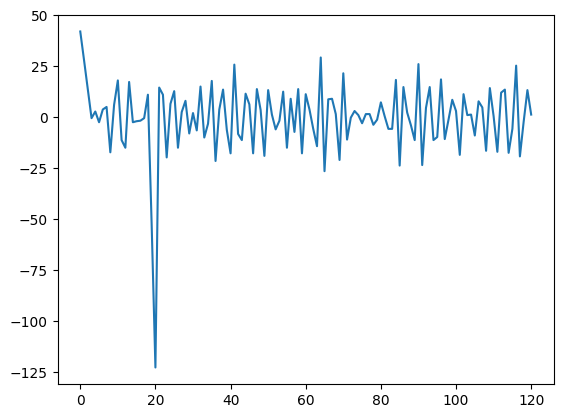

In [124]:
series = 0
velocities = []
accelerations = []
accsum = []
CoMs = []
CoM_vels = []
for (i, vel) in enumerate(positions):
    velocity = (vel[1:]-vel[:-1])*500 # 500Hz 
    acceleration = (velocity[1:]-velocity[:-1])*500
    accs = np.sqrt(acceleration[:,:,0]**2 + acceleration[:,:,1]**2)

    velocities.append(velocity)
    accelerations.append(acceleration)
    accsum.append(accs)

    mass = MASSES[PUCKS[metadata[i][0]-1]]
    CoM = (vel[:,0,[0,1]] * mass[0] + vel[:,1,[0,1]] * mass[1])/(mass[0]+mass[1])
    CoM_vel = (CoM[1:]-CoM[:-1])*500

    CoMs.append(CoM)
    CoM_vels.append(CoM_vel)
# plt.plot(accsum[series][:,0])
plt.plot(accelerations[series][:,0,0])
print(np.argmax(accsum[series][:,0] + accsum[series][:,1]))
# plt.plot(processed[28][:,0,1])

## Linear Momentum

In [125]:
linmoms = []

for (i, vel) in enumerate(velocities):
    scenario = metadata[i][0]-1
    mass = MASSES[PUCKS[scenario]]
    momentum = vel[:,:,[0,1]]
    momentum_sum = momentum[:, 0] * mass[0] + momentum[:, 1] * mass[1]
    
    linmoms.append(momentum_sum)

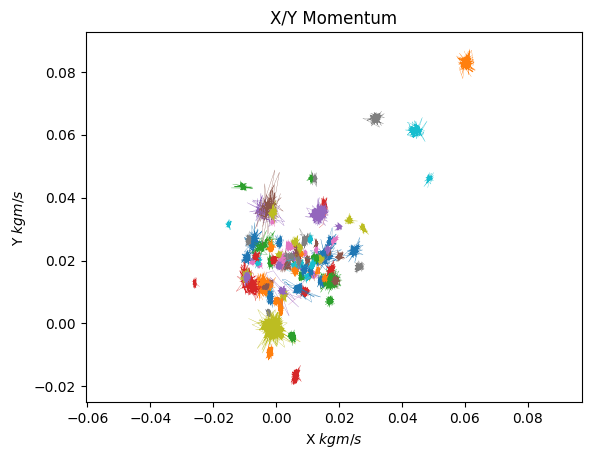

In [126]:
for mom in linmoms:
    plt.plot(mom[:,0], mom[:,1], linewidth=0.2)
plt.axis('equal')
plt.title("X/Y Momentum")
plt.xlabel("X $kgm/s$")
plt.ylabel("Y $kgm/s$")
None

## Angular Momentum

$r = v \times p = v_x p_y - v_y p_x$ 

$f = \frac{1}{2 \pi \omega}$

$L = 2 \pi M f r^2 = \frac{M r^2}{\omega}$

In [127]:
angmoms = []

for (i, (pos, vel)) in enumerate(zip(positions, velocities)):
    scenario = metadata[i][0]-1
    
    moment_of_inertia = MOMENTS_OF_INTERTIA[PUCKS[scenario]] #MASSES[PUCKS[scenario]] * RADII[PUCKS[scenario]]**2 / 2
    
    angvel = vel[:,:,2]
    
    
    # Momentum around each puck's own CoM
    rotational_momentum = np.array([
        rolling_avg(angvel[:, 0] * moment_of_inertia[0], 1),
        rolling_avg(angvel[:, 1] * moment_of_inertia[1], 1)
    ]).T

    momentum_sum = rotational_momentum[:, 0] + rotational_momentum[:, 1]
    
    # Momentum around origin
    rvel =  MASSES[PUCKS[scenario]] * (vel[:,:,1]*pos[1:,:,0] - vel[:,:,0]*pos[1:,:,1]) # [m1, m2] * [vy*px]
    
    angmom_sum = rvel[:, 0] + rvel[:, 1] + momentum_sum

    angmoms.append(rotational_momentum + rvel)

    # plt.plot(rvel[:,0]+rvel[:,1])
    # plt.plot(rvel + angular_momentum)

    # plt.scatter(momentum_sum[:,0], momentum_sum[:,1], label=i, s=0.1)
    
    # plt.plot(momentum[:, 0, 0], momentum[:, 0, 1])
    # plt.plot(momentum[:, 1, 0], momentum[:, 1, 1])

    # plt.plot(angvel[:,0])
    # plt.plot(angular_momentum[:,0], linewidth=1, label = "A: " + str(metadata[i][0]) + "_" + str(metadata[i][1]))
    # plt.plot(angular_momentum[:,1], linewidth=1, label = "B: " + str(metadata[i][0]) + "_" + str(metadata[i][1]))
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)
# plt.legend()
# plt.title("Total Angular Momentum")
# plt.xlabel("X $kgm/s$")
# plt.ylabel("rad/s")
None

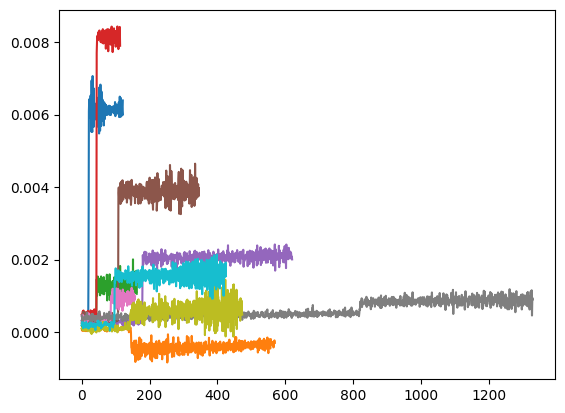

In [128]:
for mom in angmoms[0:10]:
    plt.plot(mom[:,1])

## Impact detection

In [129]:
impact_times = []
acc_sqs = []
for acc in accelerations:
    # Sum the squares of x, y accelerations for both pucks
    acc_sq = acc[:,0,0]**2+acc[:,0,1]**2+acc[:,1,0]**2+acc[:,1,1]**2
    acc_sqs.append(acc_sq)
    impact_times.append(np.argmax(acc_sq))

In [130]:
margin = 5
for (linmom, angmom, impact_time) in zip(linmoms, angmoms, impact_times):
    linavg_pre = np.average(linmom[:impact_time - margin], axis=0)
    linavg_post = np.average(linmom[impact_time + margin:], axis=0)
    
    angavg_pre = np.average(angmom[:impact_time - margin], axis=0)
    angavg_post = np.average(angmom[impact_time + margin:], axis=0)
    
    # print(np.sum(angavg_post)/np.sum(angavg_pre))

## $\alpha$ - $\omega$ relationship

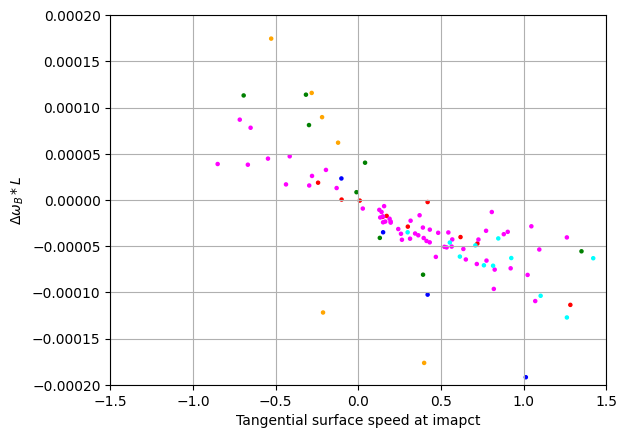

In [ ]:
%matplotlib inline
tangential_surface_velocities = []
y = []
impact_surface_velocities = []
c = []

colormap = ["red", "blue", "green", "orange", "magenta", "cyan"]

for (pos, vel, impact_time, meta) in zip(positions, velocities, impact_times, metadata):
# for (pos, vel, impact_time, meta) in zip(positions[4:5], velocities[4:5], impact_times[4:5], metadata[4:5]):
    # Velocities from puck B:s frame of referencef
    scenario = meta[0]-1

    avg_vel_pre = np.average(vel[:impact_time - 5], axis = 0)
    avg_vel_post = np.average(vel[impact_time + 5:], axis = 0)
    
    relative_vel = avg_vel_pre[0]-avg_vel_pre[1]
    relative_vel_post = avg_vel_post[0]-avg_vel_post[1]
    vel_angle = np.arctan2(relative_vel[1], relative_vel[0])
    relative_pos_at_impact = -(pos[impact_time,0]-pos[impact_time,1])
    contact_angle = np.arctan2(relative_pos_at_impact[1], relative_pos_at_impact[0])
    

    momentumchange = (relative_vel_post - relative_vel) * MASSES[PUCKS[scenario][0]]

    tangent = np.array([-np.sin(contact_angle), np.cos(contact_angle)])
    normal = np.array([np.cos(contact_angle), np.sin(contact_angle)])
        
    
    # draw_measurement(pos, 15)
    
    # plt.arrow(pos[impact_time,0,0], pos[impact_time, 0, 1], relative_pos_at_impact[0]/2, relative_pos_at_impact[1]/2, color="green")
    # plt.arrow(pos[impact_time,0,0], pos[impact_time, 0, 1], relative_vel[0]/100, relative_vel[1]/100, color="red")
    # plt.axis("equal")

    puck_a_surface_velocity = tangent * RADII[PUCKS[scenario][0]] * avg_vel_pre[0][2] + relative_vel[0:2]
    puck_b_surface_velocity = -tangent * RADII[PUCKS[scenario][1]] * avg_vel_pre[1][2]
    relative_surface_velocity = puck_a_surface_velocity - puck_b_surface_velocity
    
    impact_surface_velocities.append(relative_surface_velocity)
    
    tangential = np.dot(tangent, relative_surface_velocity)
    normal = np.dot([np.cos(contact_angle), np.sin(contact_angle)], relative_surface_velocity)

    normalimpulse = np.dot(normal, momentumchange)

    tangential_surface_velocities.append(tangential)# * np.linalg.norm(normalimpulse))
    y.append((avg_vel_post[1,2] - avg_vel_pre[1,2]) * MOMENTS_OF_INTERTIA[PUCKS[scenario][1]] )
    
    c.append(colormap[scenario])

    # print(vel_angle, contact_angle)

plt.figure()
plt.scatter(tangential_surface_velocities, y, c = c, s = 5)
plt.xlabel("Tangential surface speed at imapct")
plt.ylabel("$\\Delta\\omega_B * L$")
plt.xlim((-1.5, 1.5))
# plt.ylim((-0.2, 0.2))
# plt.ylim((-0.005, 0.005))
# plt.ylim((-0.000002, 0.000002))

# plt.xlim((-0.05, 0.05))
plt.ylim((-0.0002, 0.0002))

plt.grid()

for (i, (tangential_surface_velocity, y)) in enumerate(zip(tangential_surface_velocities, y)):
    continue
    # plt.text(x - 0.07, y- 0.1, str(metadata[i][0]) + "_" + str(metadata[i][1]), color="black")
    plt.text(tangential_surface_velocity - 0.05, y+.2, str(i))
    
plt.show()

# Visualisation

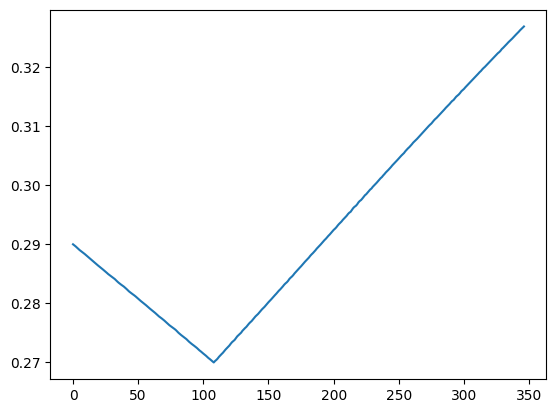

In [ ]:
series = 5
puck = 1
# plt.plot(rolling_avg(processed[series][:,puck][:,2][:-1] - processed[series][:,puck][:,2][1:], 5))
# plt.ylim(-0.005, 0.01)
# plt.plot(processed[series][:,1][:,2])
plt.plot(positions[series][:,0][:,0])
None

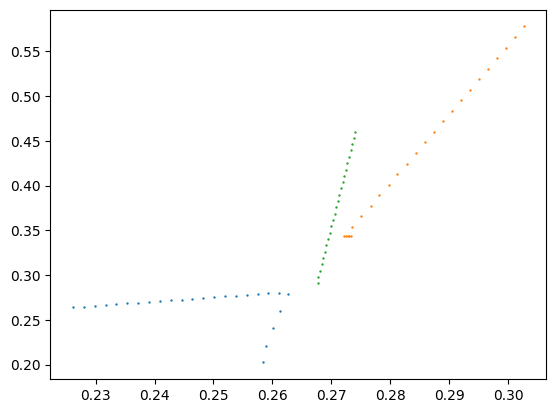

In [133]:
series = 0
subsample = 5
plt.scatter(positions[series][:,0,0][::subsample], positions[series][:,0,1][::subsample], s=0.5)
plt.scatter(positions[series][:,1,0][::subsample], positions[series][:,1,1][::subsample], s=0.5)
plt.scatter(CoMs[series][:,0][::subsample], CoMs[series][:,1][::subsample], s=0.5)

In [134]:
%matplotlib qt5
s = 15
print(tangential_surface_velocities)
t = str(metadata[s][0]) + "_" + str(metadata[s][1]) + "\n" + str(impact_surface_velocities[s]) + "\n" + str(tangential_surface_velocities[s])

radius_a = RADII[PUCKS[metadata[s][0]-1][0]]
radius_b = RADII[PUCKS[metadata[s][0]-1][1]]

print(metadata[s])

fig, ax = plt.subplots()
puck_a = patches.Circle((0.5, 0.5), radius_a)
puck_a_edge = patches.Circle((0.5, 0.5), 0.005, color="red")
puck_b = patches.Circle((0.5, 0.5), radius_b, color="red")
puck_b_edge = patches.Circle((0.5, 0.5), 0.005)
ax.add_patch(puck_a)
ax.add_patch(puck_a_edge)
ax.add_patch(puck_b)
ax.add_patch(puck_b_edge)
plt.scatter([0,1], [0, 1], s=0)

ax.axis("equal")

ax.text(0, 1, t)

def anim(frame):
    puck_a.center = positions[s][frame][0][0], positions[s][frame][0][1]
    puck_a_edge.center = positions[s][frame][0][0] + np.cos(positions[s][frame][0][2])*radius_a, positions[s][frame][0][1] + np.sin(positions[s][frame][0][2])*radius_a
    puck_b.center = positions[s][frame][1][0], positions[s][frame][1][1]
    puck_b_edge.center = positions[s][frame][1][0] + np.cos(positions[s][frame][1][2])*radius_b, positions[s][frame][1][1] + np.sin(positions[s][frame][1][2])*radius_b

ani = animation.FuncAnimation(fig = fig, func=anim, frames=len(positions[s]), interval = 10)
plt.show()

[0.1471061384559974, 0.41930625888873246, 0.6182383521933462, 1.2825201840487943, -0.10101079135278465, -0.24333441350673118, 0.7203307101933971, 0.00870616995596112, 0.1715050728425899, 0.2994869519830134, 0.41931939589442846, -0.10226757332618333, 1.0133067986274598, 0.1500444625362541, 0.8061044012264206, -1.435158961806716, 0.04083318081505409, -0.693440702028028, 0.3916052994962871, 0.1301658387749023, -0.29826738924441015, -0.010973441855815523, 1.3499113171249963, -0.3166608792727146, -0.12234988938036964, -0.21912896052387454, -0.28192650128521585, -1.3713115033121206, -0.2132705895451165, -0.5269400433587966, 0.39821370666676603, 1.0327984519127995, 0.06045977861568902, 1.046772599720599, 0.19554846795478226, 0.3953720880852959, 0.7753955193510484, 0.8074596960808325, -0.6680795641782831, 0.1628599501414253, -0.13109332969144433, 0.37064443938402347, -0.27995128470948105, -0.8506949485490283, 0.5342096637578644, -0.4373569228710956, 0.43191872864885733, 1.0947568675353034, 0.1